# 1 - LinReg Modelling

In [1]:
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import figure
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.tools
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import scipy as sp

In [2]:
df = pd.read_csv('Audi_combined_data.csv')

In [3]:
## Basic cleaning from "0 - EDA"
df7 = df.copy()

## Removing ULEZ column
df7.drop(columns='ULEZ', inplace=True)
## Dropping nulls in year, fuel, mileage, body, and transmission
df7.dropna(subset=['year', 'fuel', 'mileage', 'body', 'transmission'], inplace=True)
## Formatting rows
df7["price"] = df7["price"].replace('[£,]', '', regex=True).astype(float) ## [£,] is needed to deal with elements such as £6,600
df7['year'] = df7['year'].str.replace('\s\(.*\)$', '' , regex=True).astype(int)

In [4]:
df7.shape

(20974, 12)

In [5]:
df7.dtypes

name             object
link             object
price           float64
mileage         float64
BHP             float64
transmission     object
fuel             object
owners          float64
body             object
engine           object
year              int32
filename         object
dtype: object

## Dealing with outliers

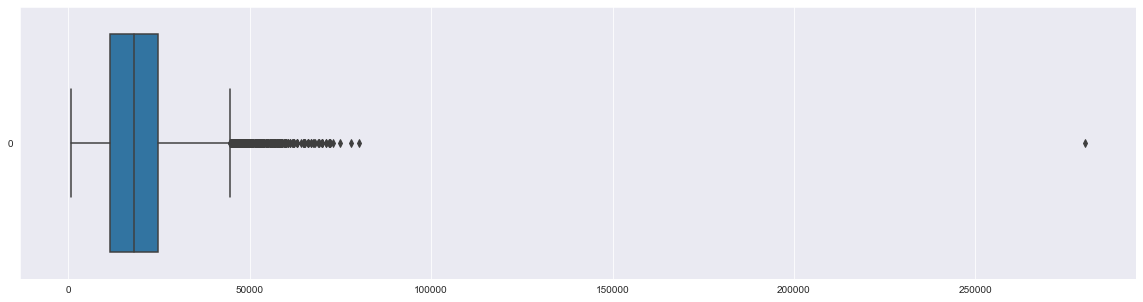

In [6]:
plt.figure(figsize = (20, 5))
sns.boxplot(data=df7['price'],
            orient='h')
plt.show()

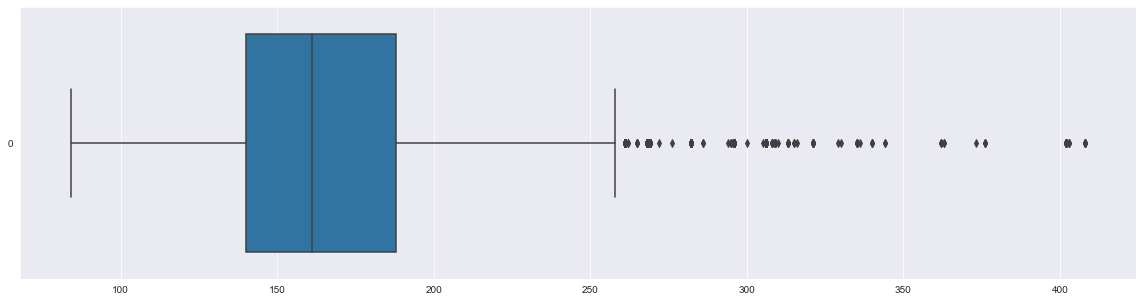

In [7]:
plt.figure(figsize = (20, 5))
sns.boxplot(data=df7['BHP'],
            orient='h')
plt.show()

In [8]:
def iqr_cars(dataframe, column):
    """This function serves to calculate the interquartile range (IQR) of values within the given column of a dataframe"""
    return dataframe[column].describe()['75%'] - dataframe[column].describe()['25%']

In [9]:
## Removing outliers for price and BHP, based on the IQR
print(df7.shape) ## Shape before removing outliers
df7 = df7.loc[( (df7['price'] < df7['price'].describe()['75%'] + 1.5 * iqr_cars(df7, 'price') )
                | (df7['price'] < df7['price'].describe()['25%'] - 1.5 * iqr_cars(df7, 'price') ) )
              & ( (df7['BHP'] < df7['BHP'].describe()['50%'] + 1.5 * iqr_cars(df7, 'BHP') )
                | (df7['BHP'] < df7['BHP'].describe()['50%'] - 1.5 * iqr_cars(df7, 'BHP') ) ) ]
print(df7.shape) ## Shape after removing outliers
df7.isna().sum() ## Number of nulls in df7

(20974, 12)
(3799, 12)


name               0
link               0
price              0
mileage            0
BHP                0
transmission       0
fuel               0
owners          2456
body               0
engine             1
year               0
filename           0
dtype: int64

Removing the row with an engine null

In [10]:
df7.dropna(subset=['engine'] ,inplace=True)
df7.engine.isna().sum()

0

## Test/Train Split

In [11]:
X = df7.drop(columns=['name','link', 'price'])
X = sm.add_constant(X) ## Adding a constant column for use in linear regression later
y = df7['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 101)

In [12]:
print(f'The length of X is {len(X)}')
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

The length of X is 3798
Shape of X_train: (3038, 10)
Shape of X_test: (760, 10)
Shape of y_train: (3038,)
Shape of y_test: (760,)


## Null handling

Checking the amount of nulls in our training data

In [13]:
X_train.isna().sum()

const              0
mileage            0
BHP                0
transmission       0
fuel               0
owners          1990
body               0
engine             0
year               0
filename           0
dtype: int64

### Owner nulls
Having checked on the autotrader website, it can be safely assumed that cars with a null value for 'owners' have in fact had one previous owner. As such, we have filled in the null values for owners with the number 1.

In [14]:
X_train['owners'].fillna(value=1, inplace=True)
X_train['owners'] = X_train['owners'].astype(int) ## Converting the number of previous owners to an integer.

In [15]:
X_train.owners.isna().sum() ## No more nulls in 'owners'

0

### Engine formatting

In [16]:
## Formatting engine
X_train['engine'] = X_train["engine"].replace('L', '', regex=True).astype(float) ## Removing the L from engine and turning the column into a float
X_train['engine'].value_counts() ## Seeing the different values for engine

2.0    1650
1.4     404
1.0     276
1.6     244
1.5     211
1.8     103
3.0      78
1.9      26
2.7      25
1.2      19
2.5       1
2.4       1
Name: engine, dtype: int64

## New columns

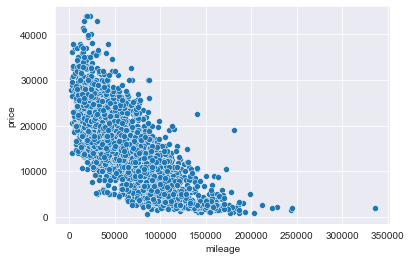

In [17]:
## Scatterplot showing the relationship of mileage with price in df7
sns.scatterplot(x='mileage',
                y='price',
                data = df7)
plt.show()

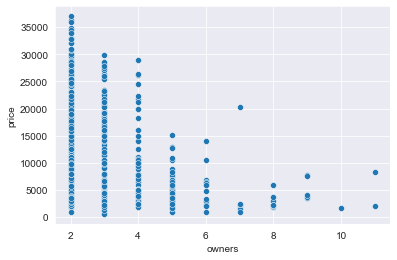

In [18]:
## Scatterplot showing the relationship of owners with price in df7
sns.scatterplot(x='owners',
                y='price',
                data = df7)
plt.show()

In both of the plots above, there is a vaguely exponential relationship. As such, we have decided to add two new columns which take the logarithm of mileage and owners

In [19]:
## New columns
X_train['log_mileage'] = np.log(X_train['mileage'])
X_train['log_owners'] = np.log(X_train['owners'])

## One-hot encoding
The remaining categorical columns of 'transmission', 'fuel', and 'body' can all be one-hot encoded.

In [20]:
## One-hot encoding
# Transmission
X_train = pd.get_dummies(X_train, columns = ['transmission'], drop_first = False, prefix = 'gear_type')
# fuel
X_train = pd.get_dummies(X_train, columns = ['fuel'], drop_first = False, prefix = 'fuel_type')
# body
X_train = pd.get_dummies(X_train, columns = ['body'], drop_first = False, prefix = 'body_type')

In [21]:
X_train.head() ## Checking the dataframe

,const,mileage,BHP,owners,engine,year,filename,log_mileage,log_owners,gear_type_Automatic,gear_type_Manual,fuel_type_Diesel,fuel_type_Petrol,fuel_type_Petrol Plug-in Hybrid,body_type_Convertible,body_type_Coupe,body_type_Estate,body_type_Hatchback,body_type_SUV,body_type_Saloon
14137,1.0,34000.0,148.0,1,1.4,2018,./Datasets\Audi_Q2.txt,10.434116,0.0,1,0,0,1,0,0,0,0,0,1,0
11699,1.0,108000.0,204.0,1,3.0,2012,./Datasets\Audi_A6 Avant.txt,11.589887,0.0,1,0,1,0,0,0,0,1,0,0,0
15513,1.0,54000.0,148.0,1,2.0,2015,./Datasets\Audi_Q3.txt,10.896739,0.0,0,1,1,0,0,0,0,0,0,1,0
2506,1.0,42000.0,94.0,1,1.0,2020,./Datasets\Audi_A1.txt,10.645425,0.0,1,0,0,1,0,0,0,0,1,0,0
7922,1.0,15535.0,148.0,1,2.0,2020,./Datasets\Audi_A4 Avant.txt,9.650851,0.0,1,0,0,1,0,0,0,1,0,0,0


In [22]:
X_train.dtypes ## Checking the dtypes are all in good order

const                              float64
mileage                            float64
BHP                                float64
owners                               int32
engine                             float64
year                                 int32
filename                            object
log_mileage                        float64
log_owners                         float64
gear_type_Automatic                  uint8
gear_type_Manual                     uint8
fuel_type_Diesel                     uint8
fuel_type_Petrol                     uint8
fuel_type_Petrol Plug-in Hybrid      uint8
body_type_Convertible                uint8
body_type_Coupe                      uint8
body_type_Estate                     uint8
body_type_Hatchback                  uint8
body_type_SUV                        uint8
body_type_Saloon                     uint8
dtype: object

In [23]:
X_train.columns ## Columns for X_train

Index(['const', 'mileage', 'BHP', 'owners', 'engine', 'year', 'filename',
       'log_mileage', 'log_owners', 'gear_type_Automatic', 'gear_type_Manual',
       'fuel_type_Diesel', 'fuel_type_Petrol',
       'fuel_type_Petrol Plug-in Hybrid', 'body_type_Convertible',
       'body_type_Coupe', 'body_type_Estate', 'body_type_Hatchback',
       'body_type_SUV', 'body_type_Saloon'],
      dtype='object')

## Linear regression modelling (i)
#### Training

Firstly, let's test a linear regression model with all of our feature columns.

In [24]:
## Now that it is no longer relevant, let's drop the filename column
X_train.drop(columns=['filename'], inplace=True)

In [25]:
y_train.shape

(3038,)

In [26]:
X_train.shape

(3038, 19)

In [27]:
feature_cols = list(X_train.columns)

lin_reg = sm.OLS(y_train, X_train[feature_cols]) ## Why is there an error here?! Drastic measure: remove the engine null earlier
results = lin_reg.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     1698.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:29:30   Log-Likelihood:                -27934.
No. Observations:                3038   AIC:                         5.590e+04
Df Residuals:                    3022   BIC:                         5.600e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                           -1.124e+06   1.82e+04    -61.698      0.000   -1.16e+06   -1.09e+06
mileage                            -0.0162      0.003     -4.733      0.000      -0.023      -0.010
BHP                                41.4016      2.360     17.545      0.000      36.775      46.028
owners                            170.7518    137.169      1.245      0.213     -98.203     439.706
engine                           1572.4437    241.354      6.515      0.000    1099.209    2045.678
year                             1133.5430     17.939     63.189      0.000    1098.369    1168.717
log_mileage                     -2793.1221    162.932    -17.143      0.000   -3112.592   -2473.652
log_owners                       -341.6415    292.693     -1.167      0.243    -915.540     232.257
gear_type_Automatic             -5.609e+05   9113.269    -61.546      0.000   -5.79e+05   -5.43e+05
gear_type_Manual                -5.628e+05   9098.761    -61.849      0.000   -5.81e+05   -5.45e+05
fuel_type_Diesel                -3.747e+05   6092.418    -61.510      0.000   -3.87e+05   -3.63e+05
fuel_type_Petrol                -3.747e+05   6062.761    -61.807      0.000   -3.87e+05   -3.63e+05
fuel_type_Petrol Plug-in Hybrid -3.742e+05   6076.530    -61.576      0.000   -3.86e+05   -3.62e+05
body_type_Convertible            -1.88e+05   3010.272    -62.438      0.000   -1.94e+05   -1.82e+05
body_type_Coupe                 -1.881e+05   3040.046    -61.889      0.000   -1.94e+05   -1.82e+05
body_type_Estate                -1.869e+05   3052.161    -61.224      0.000   -1.93e+05   -1.81e+05
body_type_Hatchback             -1.878e+05   3037.886    -61.817      0.000   -1.94e+05   -1.82e+05
body_type_SUV                   -1.853e+05   3050.627    -60.741      0.000   -1.91e+05   -1.79e+05
body_type_Saloon                -1.876e+05   3048.697    -61.526      0.000   -1.94e+05   -1.82e+05
==============================================================================
Omnibus:                      653.553   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3084.316
Skew:                           0.955   Prob(JB):                         0.00
Kurtosis:                       7.552   Cond. No.                     4.04e+20
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.64e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [28]:
X_train['price_pred'] = results.predict(X_train[feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['price_pred'])
print(f'the RMSE is {rmse}')
print(results.params)

the RMSE is 2382.7364652851106
const                             -1.123632e+06
mileage                           -1.624791e-02
BHP                                4.140159e+01
owners                             1.707518e+02
engine                             1.572444e+03
year                               1.133543e+03
log_mileage                       -2.793122e+03
log_owners                        -3.416415e+02
gear_type_Automatic               -5.608818e+05
gear_type_Manual                  -5.627503e+05
fuel_type_Diesel                  -3.747416e+05
fuel_type_Petrol                  -3.747203e+05
fuel_type_Petrol Plug-in Hybrid   -3.741702e+05
body_type_Convertible             -1.879557e+05
body_type_Coupe                   -1.881444e+05
body_type_Estate                  -1.868651e+05
body_type_Hatchback               -1.877934e+05
body_type_SUV                     -1.852996e+05
body_type_Saloon                  -1.875739e+05
dtype: float64


Using all our feature columns, we get a base RMSE of 2382, and R^2 of 0.894.

Now let's look at using columns according to their variance inflation factor, or through stepwise selection.

In [29]:
## "Lisa's code", taken from stat.statexchange.com

def calculate_vif(X, thresh = 5.0):
    variables = list(range(X.shape[1]))
    dropped = True
    while dropped:
        dropped = False
        # this bit uses list comprehension to gather all the VIF values of the different variables
        vif = [variance_inflation_factor(X.iloc[:, variables].values, ix)
               for ix in range(X.iloc[:, variables].shape[1])]

        maxloc = vif.index(max(vif)) # getting the index of the highest VIF value
        if max(vif) > thresh:
            print('dropping \'' + X.iloc[:, variables].columns[maxloc] +
                  '\' at index: ' + str(maxloc))
            del variables[maxloc] # we delete the highest VIF value on condition that it's higher than the threshold
            dropped = True # if we deleted anything, we set the 'dropped' value to True to stay in the while loop

    print('Remaining variables:')
    print(X.columns[variables]) # finally, we print the variables that are still in our set
    return X.iloc[:, variables] # and return our X cut down to the remaining variables

In [30]:
calculate_vif(X_train.drop(columns=['price_pred']), 5.0) ## Only works if I drop engine

C:\Users\Isaac\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\Isaac\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


dropping 'gear_type_Automatic' at index: 8
dropping 'fuel_type_Diesel' at index: 9
dropping 'body_type_Convertible' at index: 11
dropping 'const' at index: 0
dropping 'log_mileage' at index: 5
dropping 'year' at index: 4
dropping 'engine' at index: 3
dropping 'owners' at index: 2
dropping 'BHP' at index: 1
Remaining variables:
Index(['mileage', 'log_owners', 'gear_type_Manual', 'fuel_type_Petrol',
       'fuel_type_Petrol Plug-in Hybrid', 'body_type_Coupe',
       'body_type_Estate', 'body_type_Hatchback', 'body_type_SUV',
       'body_type_Saloon'],
      dtype='object')


,mileage,log_owners,gear_type_Manual,fuel_type_Petrol,fuel_type_Petrol Plug-in Hybrid,body_type_Coupe,body_type_Estate,body_type_Hatchback,body_type_SUV,body_type_Saloon
14137,34000.0,0.000000,0,1,0,0,0,0,1,0
11699,108000.0,0.000000,0,0,0,0,1,0,0,0
15513,54000.0,0.000000,1,0,0,0,0,0,1,0
2506,42000.0,0.000000,0,1,0,0,0,1,0,0
7922,15535.0,0.000000,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
3094,153938.0,0.000000,1,0,0,0,0,1,0,0
7783,37000.0,0.693147,0,1,0,0,1,0,0,0
6715,10000.0,0.000000,1,1,0,0,0,1,0,0
7596,72981.0,0.693147,0,0,0,0,1,0,0,0


In [31]:
## Feature cols from VIF.
vif_feature_cols = ['mileage', 'log_owners', 'gear_type_Manual', 'fuel_type_Petrol',
                    'fuel_type_Petrol Plug-in Hybrid', 'body_type_Coupe',
                    'body_type_Estate', 'body_type_Hatchback', 'body_type_SUV',
                    'body_type_Saloon', 'const']
## Note that we have added the constant column back in at the end.

In [32]:
## Linear regression test on training set with VIF feature columns

lin_reg = sm.OLS(y_train, X_train[vif_feature_cols])
results = lin_reg.fit()
results.summary()

## Adj R^2 is 0.712

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.711
Method:                 Least Squares   F-statistic:                     749.5
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:29:31   Log-Likelihood:                -29450.
No. Observations:                3038   AIC:                         5.892e+04
Df Residuals:                    3027   BIC:                         5.899e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
mileage                            -0.1464      0.002    -63.532      0.000      -0.151      -0.142
log_owners                      -1077.2227    166.915     -6.454      0.000   -1404.501    -749.944
gear_type_Manual                -3788.3757    152.523    -24.838      0.000   -4087.434   -3489.317
fuel_type_Petrol                 -891.9164    164.268     -5.430      0.000   -1214.005    -569.828
fuel_type_Petrol Plug-in Hybrid  1206.4546    971.979      1.241      0.215    -699.351    3112.260
body_type_Coupe                  3038.6280    637.956      4.763      0.000    1787.757    4289.499
body_type_Estate                 4216.0994    643.010      6.557      0.000    2955.319    5476.880
body_type_Hatchback              1434.1027    607.435      2.361      0.018     243.076    2625.130
body_type_SUV                    5609.9444    621.421      9.028      0.000    4391.495    6828.394
body_type_Saloon                 3432.9863    622.932      5.511      0.000    2211.575    4654.398
const                            2.391e+04    637.045     37.539      0.000    2.27e+04    2.52e+04
==============================================================================
Omnibus:                       88.022   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.790
Skew:                           0.155   Prob(JB):                     6.13e-42
Kurtosis:                       4.184   Cond. No.                     1.42e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [33]:
X_train['price_pred'] = results.predict(X_train[vif_feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['price_pred'])
print(f'the RMSE is {rmse}') ## RMSE of 3924
print(results.params)

the RMSE is 3924.4717526844174
mileage                               -0.146429
log_owners                         -1077.222672
gear_type_Manual                   -3788.375671
fuel_type_Petrol                    -891.916400
fuel_type_Petrol Plug-in Hybrid     1206.454636
body_type_Coupe                     3038.627980
body_type_Estate                    4216.099436
body_type_Hatchback                 1434.102683
body_type_SUV                       5609.944438
body_type_Saloon                    3432.986324
const                              23914.059197
dtype: float64


The RMSE and adjusted R-squared for the model with VIF feature columns are both worse for this model.

In [34]:
## Code for stepwise selection from notebook part 4

def stepwise_selection(X, y, threshold_in = 0.01, threshold_out = 0.05, verbose = True):
    # The function is checking for p-values (whether features are statistically significant), the lower the better
    included = [] # this is going to be the list of features we keep
    while True:
        changed = False
        # forward step
        excluded = list(set(X.columns) - set(included))
        new_pval = pd.Series(index = excluded, dtype = 'float64')
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included + [new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        # we add the feature with the lowest (best) p-value under the threshold to our 'included' list
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval)) # specifying the verbose text

        # backward step: removing features if new features added to the list make them statistically insignificant
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()

        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        # if the p-value exceeds the upper threshold, the feature will be dropped from the 'included' list
        if worst_pval > threshold_out:
            changed = True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [35]:
stepwise_cols = stepwise_selection(X_train.drop(columns=['price_pred']), y_train)

print('resulting features:')
print(stepwise_cols)

Add  year                           with p-value 0.0
Add  const                          with p-value 0.0
Add  BHP                            with p-value 2.31619e-243
Add  log_mileage                    with p-value 1.16904e-206
Add  body_type_SUV                  with p-value 2.74528e-103
Add  gear_type_Automatic            with p-value 2.21586e-89
Add  gear_type_Manual               with p-value 0.0
Add  engine                         with p-value 2.09e-18
Add  body_type_Estate               with p-value 5.62293e-09
Add  mileage                        with p-value 1.69928e-05
Add  body_type_Coupe                with p-value 0.00419848
resulting features:
['year', 'const', 'BHP', 'log_mileage', 'body_type_SUV', 'gear_type_Automatic', 'gear_type_Manual', 'engine', 'body_type_Estate', 'mileage', 'body_type_Coupe']


In [36]:
## Feature columns from stepwise selection
stepwise_feature_cols = ['year', 'const', 'BHP', 'log_mileage', 'body_type_SUV', 'gear_type_Automatic', 'gear_type_Manual', 'engine', 'body_type_Estate', 'mileage', 'body_type_Coupe']

In [37]:
## Linear regression test on training set with stepwise feature columns

lin_reg = sm.OLS(y_train, X_train[stepwise_feature_cols])
results = lin_reg.fit()
results.summary()

## Adj R^2 is 0.894

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     2831.
Date:                Thu, 09 Feb 2023   Prob (F-statistic):               0.00
Time:                        10:29:33   Log-Likelihood:                -27937.
No. Observations:                3038   AIC:                         5.589e+04
Df Residuals:                    3028   BIC:                         5.595e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
year                 1134.4881     16.675     68.037      0.000    1101.793    1167.183
const                 -1.5e+06   2.25e+04    -66.651      0.000   -1.54e+06   -1.46e+06
BHP                    42.0897      2.142     19.654      0.000      37.891      46.289
log_mileage         -2841.2318    158.441    -17.932      0.000   -3151.895   -2530.569
body_type_SUV        2398.6249    114.732     20.906      0.000    2173.665    2623.585
gear_type_Automatic -7.488e+05   1.13e+04    -66.521      0.000   -7.71e+05   -7.27e+05
gear_type_Manual    -7.507e+05   1.12e+04    -66.781      0.000   -7.73e+05   -7.29e+05
engine               1585.7196    189.500      8.368      0.000    1214.158    1957.281
body_type_Estate      816.5405    151.469      5.391      0.000     519.548    1113.533
mileage                -0.0150      0.003     -4.448      0.000      -0.022      -0.008
body_type_Coupe      -457.8385    159.803     -2.865      0.004    -771.171    -144.506
==============================================================================
Omnibus:                      652.156   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3104.812
Skew:                           0.950   Prob(JB):                         0.00
Kurtosis:                       7.573   Cond. No.                     2.55e+18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.17e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [38]:
X_train['price_pred'] = results.predict(X_train[stepwise_feature_cols])
rmse = statsmodels.tools.eval_measures.rmse(y_train, X_train['price_pred'])
print(f'the RMSE is {rmse}') ## RMSE of 2384
print(results.params)

the RMSE is 2384.7925161498233
year                   1.134488e+03
const                 -1.499547e+06
BHP                    4.208970e+01
log_mileage           -2.841232e+03
body_type_SUV          2.398625e+03
gear_type_Automatic   -7.488307e+05
gear_type_Manual      -7.507164e+05
engine                 1.585720e+03
body_type_Estate       8.165405e+02
mileage               -1.500031e-02
body_type_Coupe       -4.578385e+02
dtype: float64


This model performs similarly to our first one, but includes many less columns. As such, it is our best model.

## Linear regression modelling (ii)
#### Testing

In order to test our model on our Test dataset, we must first feature engineer it.

In [39]:
X_test.head()

,const,mileage,BHP,transmission,fuel,owners,body,engine,year,filename
14551,1.0,39500.0,114.0,Manual,Petrol,2.0,SUV,1.0L,2019,./Datasets\Audi_Q2.txt
1648,1.0,47000.0,123.0,Manual,Petrol,NaN,Hatchback,1.4L,2018,./Datasets\Audi_A1.txt
14006,1.0,35587.0,114.0,Automatic,Diesel,NaN,SUV,1.6L,2018,./Datasets\Audi_Q2.txt
7615,1.0,44000.0,148.0,Manual,Diesel,2.0,Estate,2.0L,2017,./Datasets\Audi_A4 Avant.txt
16047,1.0,38316.0,148.0,Automatic,Petrol,NaN,SUV,1.4L,2018,./Datasets\Audi_Q3.txt


In [40]:
X_test.dtypes

const           float64
mileage         float64
BHP             float64
transmission     object
fuel             object
owners          float64
body             object
engine           object
year              int32
filename         object
dtype: object

In [41]:
## Here we define a feature engineering function.

def feature_eng(data):

    data['engine'] = data["engine"].replace('L', '', regex=True).astype(float)
    data['owners'].fillna(value=1, inplace=True)
    data['owners'] = data['owners'].astype(int)

    data['log_mileage'] = np.log(data['mileage'])
    data['log_owners'] = np.log(data['owners'])

    data = pd.get_dummies(data, columns = ['transmission'], drop_first = False, prefix = 'gear_type')
    data = pd.get_dummies(data, columns = ['fuel'], drop_first = False, prefix = 'fuel_type')
    data = pd.get_dummies(data, columns = ['body'], drop_first = False, prefix = 'body_type')

    data.drop(columns=['filename'])

    return data

In [42]:
feature_eng(X_test)

,const,mileage,BHP,owners,engine,year,filename,log_mileage,log_owners,gear_type_Automatic,gear_type_Manual,fuel_type_Diesel,fuel_type_Petrol,fuel_type_Petrol Plug-in Hybrid,body_type_Convertible,body_type_Coupe,body_type_Estate,body_type_Hatchback,body_type_SUV,body_type_Saloon
14551,1.0,39500.0,114.0,2,1.0,2019,./Datasets\Audi_Q2.txt,10.584056,0.693147,0,1,0,1,0,0,0,0,0,1,0
1648,1.0,47000.0,123.0,1,1.4,2018,./Datasets\Audi_A1.txt,10.757903,0.000000,0,1,0,1,0,0,0,0,1,0,0
14006,1.0,35587.0,114.0,1,1.6,2018,./Datasets\Audi_Q2.txt,10.479736,0.000000,1,0,1,0,0,0,0,0,0,1,0
7615,1.0,44000.0,148.0,2,2.0,2017,./Datasets\Audi_A4 Avant.txt,10.691945,0.693147,0,1,1,0,0,0,0,1,0,0,0
16047,1.0,38316.0,148.0,1,1.4,2018,./Datasets\Audi_Q3.txt,10.553623,0.000000,1,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11986,1.0,43177.0,187.0,1,2.0,2017,./Datasets\Audi_A6 Avant.txt,10.673063,0.000000,1,0,1,0,0,0,0,1,0,0,0
6098,1.0,17782.0,114.0,3,1.0,2019,./Datasets\Audi_A3.txt,9.785942,1.098612,0,1,0,1,0,0,0,0,1,0,0
2435,1.0,20500.0,148.0,1,1.5,2020,./Datasets\Audi_A1.txt,9.928180,0.000000,1,0,0,1,0,0,0,0,1,0,0
15732,1.0,72115.0,148.0,2,2.0,2017,./Datasets\Audi_Q3.txt,11.186017,0.693147,1,0,1,0,0,0,0,0,0,1,0


In [43]:
X_test = feature_eng(X_test)
X_test = X_test[stepwise_feature_cols]

In [44]:
X_test['price_pred'] = results.predict(X_test)
rmse = statsmodels.tools.eval_measures.rmse(y_test, X_test['price_pred'])
print(f'the RMSE is {rmse}')

the RMSE is 2638.371613041431


Comparing our predictions to the actual prices

In [45]:
X_test['price'] = pd.Series(y_test)
X_test[['price','price_pred']]

,price,price_pred
14551,18000.0,18386.292618
1648,14245.0,15259.832962
14006,20295.0,20444.009276
7615,15650.0,17177.962398
16047,22943.0,21307.048825
...,...,...
11986,23299.0,20771.132041
6098,19500.0,18581.071233
2435,21990.0,23380.245292
15732,16500.0,18820.217559


## Plotting residuals

In [46]:
test_residuals = y_test - X_test['price_pred']

In this first graph, we see that the residuals follows a vaguely normal distribution, centred near zero.

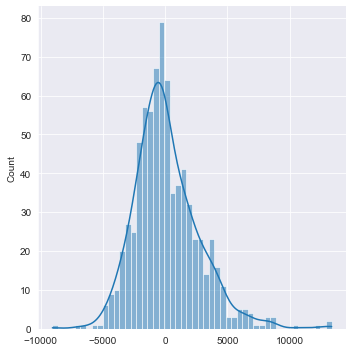

In [47]:
sns.displot(test_residuals, bins=50, kde=True)
plt.show()

In this next graph, we can see that our residuals increase at the extremities of our price range. For the rest of the data, the residuals are fairly good - concentrated around zero.

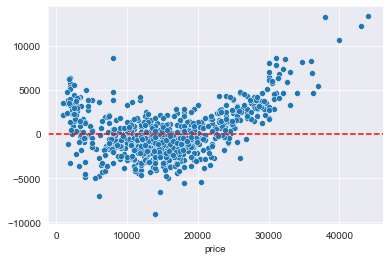

In [48]:
sns.scatterplot(x=y_test,
                y=test_residuals)
plt.axhline(y=0,
            color='r',
            ls='--')
plt.show()

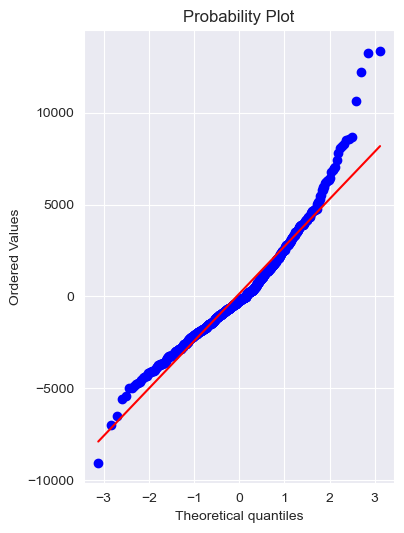

In [49]:
fig, ax = plt.subplots(figsize=(4,6), dpi=100)
_ = sp.stats.probplot(test_residuals, plot=ax)